<a href="https://colab.research.google.com/github/hussienalbared/CSSHTMLLandingPage/blob/master/Copy_of_assignment2_cuda_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.style.use('seaborn-v0_8')

# Train and compare the MLP from Assignment 1 and a simple CNN on the Fashion MNIST dataset (available in PyTorch) with somewhat optimized hyper-parameters

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
 
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 17597289.93it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302072.83it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5577385.50it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6709843.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
B_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE, 
                                          shuffle=False)

In [ ]:
iterator = iter(test_loader)

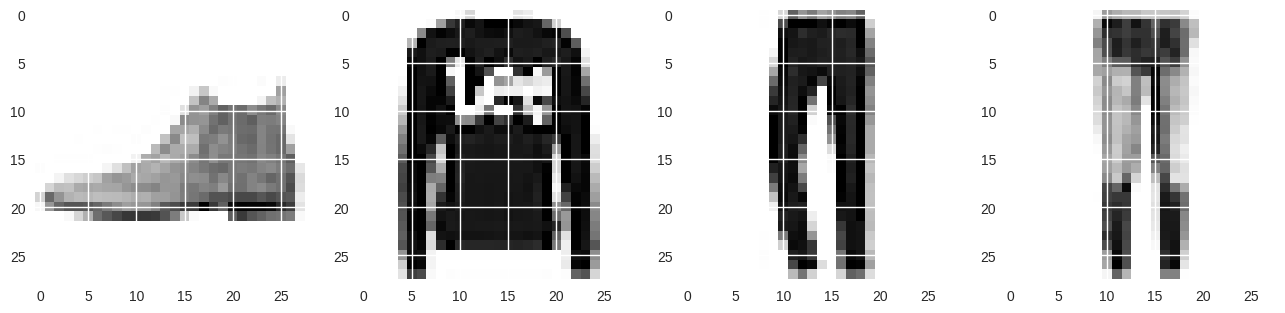

In [ ]:
b = next(iterator)
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(16, 4)
for i in range(4):
    ax[i].imshow(b[0][i, 0])

In [ ]:
# MLP
class MLP(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, n_hidden_layers = 2):

        super().__init__()

        modules = []
        modules.append(nn.Linear(in_features=input_dim, out_features=hidden_dim))
        modules.append(nn.ReLU())

        for i in range(n_hidden_layers):
          modules.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
          modules.append(nn.ReLU())

        modules.append(nn.Linear(in_features=hidden_dim, out_features=output_dim))

        self.layers = nn.Sequential(*modules)
         
    def forward(self, x):
        pred = self.layers(x)
        return pred

In [ ]:
def  pooling_(pooling_type:str):
   
   if pooling_type=="AVE":
         pooling=nn.AvgPool2d(kernel_size=2)
   else:
          pooling=nn.MaxPool2d(kernel_size=2)
   return pooling
  

In [ ]:
pooling_("AVE")

AvgPool2d(kernel_size=2, stride=2, padding=0)

In [ ]:
class CNN(nn.Module):
    def __init__(self,poolingType:str):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        # (1,28,28)
        conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        # (16, 24, 24)
        relu1 = nn.ReLU()
        #maxpool1 = nn.MaxPool2d(kernel_size=2)
       

        maxpool1 = pooling_(poolingType)
        # (16, 12, 12)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
            )
      
        # layer 2
        # (16, 12, 12)
        conv2 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=5, stride=1, padding=0)
        # (32, 8, 8)
        relu2 = nn.ReLU()
        #maxpool2 = nn.MaxPool2d(kernel_size=2)
        maxpool2 = pooling_(poolingType)
        # (32, 4, 4)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
            )
        
        # fully connected classifier
        in_dim = 32 * 4 * 4
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1) # (B, 32, 4 ,4 ) -> (B, 32 * 4 * 4)
        out2_flat = out2.view(cur_b_size, -1)
        y = self.fc(out2_flat)
        return y
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
mlp = MLP(input_dim=784, hidden_dim=128, output_dim=10, n_hidden_layers = 2)
mlp = mlp.to(device)
print(mlp)

In [ ]:
cnn = CNN(poolingType="AVE")
cnn = cnn.to(device)
print(cnn)

In [ ]:
LR = 3e-4
EPOCHS = 10
EVAL_FREQ = 1
SAVE_FREQ = 10

In [ ]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [ ]:
def train_model(model,EPOCHS,criterion, optimizer):
  loss_hist = []
  
  for epoch in range(init_epoch, EPOCHS):
      loss_list = []
      progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
      for i, (images, labels) in progress_bar:
          images, labels = images.to(device), labels.to(device)
          
          # Clear gradients w.r.t. parameters
          optimizer.zero_grad()
          
          # Forward pass to get output/logits
          if model.__class__.__name__ == 'CNN':
            outputs = model(images)
          else:
            flattened_imgs = images.flatten(start_dim=1)
            outputs = model(flattened_imgs)
          
          # Calculate Loss: softmax --> cross entropy loss
          loss = criterion(outputs, labels)
          loss_list.append(loss.item())
          
          # Getting gradients w.r.t. parameters
          loss.backward()
          
          # Updating parameters
          optimizer.step()
          progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
      loss_hist.append(np.mean(loss_list))
      if model.__class__.__name__ == 'CNN':
        stats["epoch"].append(epoch)
        stats["train_loss"].append(loss_hist[-1])
      
      # evaluating model
      if epoch % EVAL_FREQ == 0:
          accuracy, valid_loss = eval_model(model,criterion=criterion)  
          print(f"Accuracy at epoch {epoch}: {accuracy}%")
      else:   
          accuracy, valid_loss = -1, -1
      if model.__class__.__name__ == 'CNN':
        stats["accuracy"].append(accuracy)
        stats["valid_loss"].append(valid_loss) 
        # saving checkpoint
          save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)

In [ ]:
@torch.no_grad()
def eval_model(model,criterion):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss


def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [ ]:
accuracy, _ = eval_model(model=cnn,criterion=criterion, optimizer=optimizer,)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

TypeError: ignored

In [ ]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

In [ ]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [ ]:
def plt_(epochs,accuracy):
  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(16,5)

  ax[0].plot(epochs[eval_idx]+1, accuracy[eval_idx], c="red", label="Accuracy", linewidth=3)
  ax[0].legend(loc="best")
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Classification Accuracy")
  ax[0].set_title("Eval Accuracy Progress")

  IDX = 8
  zoomed = accuracy[IDX:]
  filtered = smooth(zoomed, K=9)

  ax[1].plot(epochs[IDX:]+1, accuracy[IDX:], c="red", label="Accuracy", linewidth=3)
  ax[1].plot(epochs[IDX:]+1, filtered, c="blue", label="Smoothed Accuracy", linewidth=3)
  ax[1].legend(loc="best")
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Classification Accuracy")
  ax[1].set_title("Eval Accuracy Progress Focused on Flat Area")

  plt.show()

In [ ]:
def plot_filters_single_channel_big(t):
    
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
          
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='Greys', ax=ax, cbar=False)

In [ ]:
def polt_train_eval(train_loss,eval_loss,epochs):
  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(16,5)

  for a in ax:

      a.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
      a.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
  #     a.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
      a.legend(loc="best")
      a.set_xlabel("Epochs")
      a.set_ylabel("CE Loss value")

  ax[0].set_title("Training-Eval Progress")
  ax[1].set_title("Training-Eval Progress (Log)")
  ax[1].set_yscale("log")

  plt.show()

In [ ]:
def plot_filters_single_channel(t):
    
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols
    
    npimg = np.array(t, np.float32)
    
    count = 0
    
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j], np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    

In [ ]:
def plot_filters_multi_channel(t):
    
    num_kernels = t.shape[0]    
    
    num_cols = 12
    num_rows = num_kernels
    
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        npimg = np.array(t[i], np.float32)
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_weights(model, layer, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  
  print(type(layer))
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data
    print(type(weight_tensor))
    weight_tensor= weight_tensor.cpu().numpy()
    if single_channel:
      plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        


In [ ]:
# Visualize several convolutional kernels and activations from the first two convolutional layers

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.Tensor'>


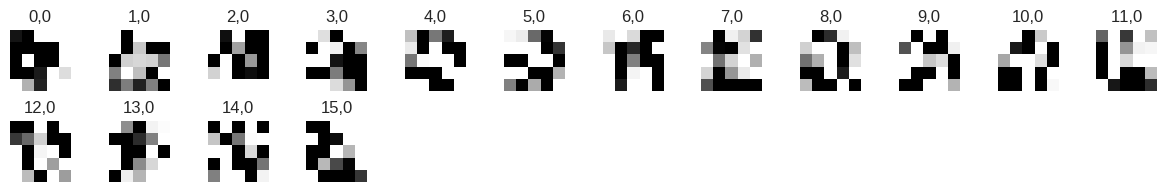

In [ ]:
#visualize weights for alexnet - first conv layer
conv1=cnn.layer1[0]
plot_weights(cnn, conv1, single_channel = True)

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.Tensor'>


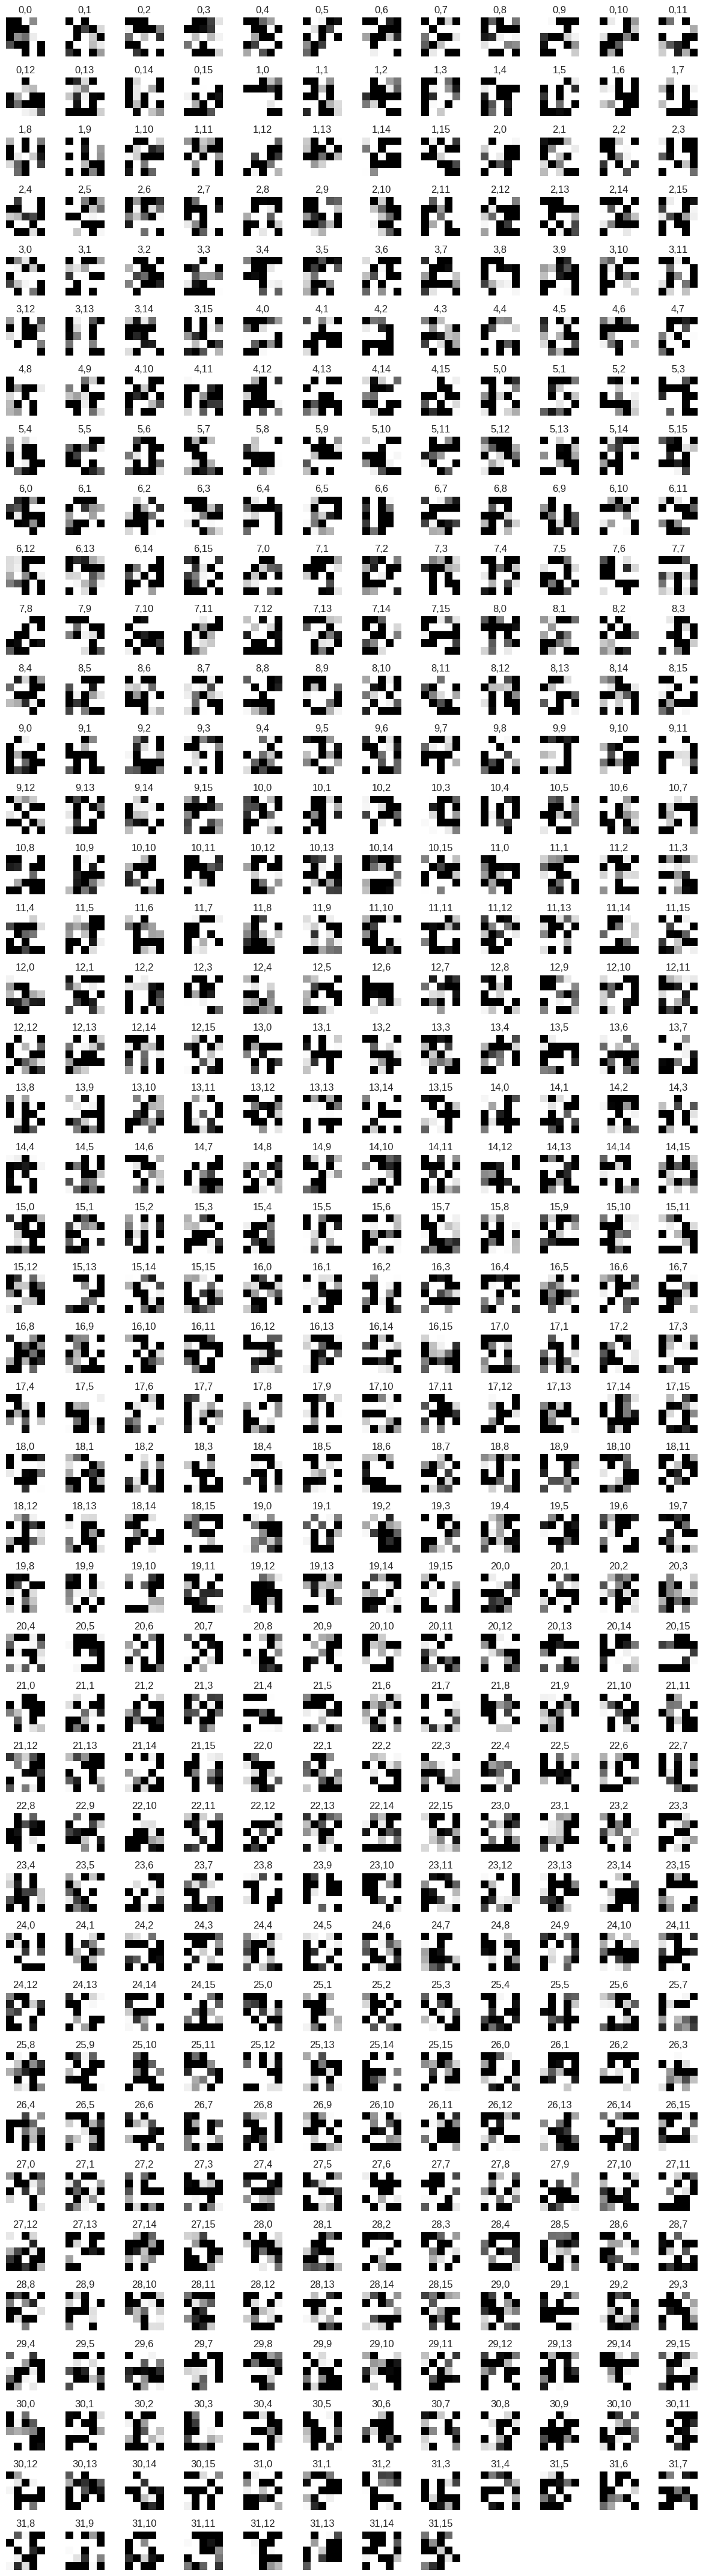

In [ ]:
conv2=cnn.layer2[0]
plot_weights(cnn, conv2, single_channel = True)

In [ ]:
def visualize_activations_conv_layers (conv_layers=[conv1,conv2],image =b[0][0, 0]):
  outputs = []
  

  image=torch.unsqueeze(image, dim=0).cuda()
  names = []
  for layer in conv_layers[0:]:
      image = layer(image)
      outputs.append(image)
      names.append(str(layer))
  #print feature_maps
  for feature_map in outputs:
      print(feature_map.shape)
  return outputs ,names   

In [ ]:
outputs,names=visualize_activations_conv_layers()

torch.Size([16, 24, 24])
torch.Size([32, 20, 20])


In [ ]:
def print_shape_output(outputs):
  processed = []
  for feature_map in outputs:
      feature_map = feature_map.squeeze(0)
      gray_scale = torch.sum(feature_map,0)
      gray_scale = gray_scale / feature_map.shape[0]
      processed.append(gray_scale.data.cpu().numpy())
  for fm in processed:
      print(fm.shape)
  return  processed   

In [ ]:
processed=print_shape_output(outputs=outputs,)

(24, 24)
(20, 20)


In [ ]:
def show_image_after_con_layers(processed,names):
  fig = plt.figure(figsize=(30, 50))
  for i in range(len(processed)):
      a = fig.add_subplot(5, 4, i+1)
      imgplot = plt.imshow(processed[i])
      a.axis("off")
      a.set_title(names[i].split('(')[0], fontsize=30)
  plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

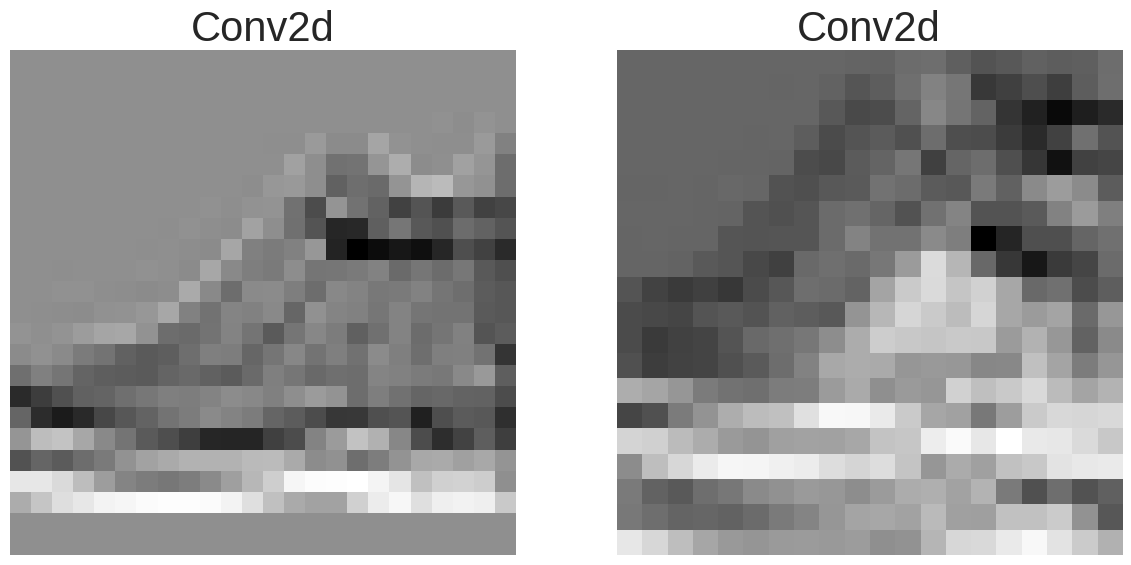

In [ ]:
show_image_after_con_layers(processed=processed,names=names)

In [ ]:
cnn_max_pooling = CNN(poolingType="MAX")
cnn_max_pooling = cnn_max_pooling.to(device)

In [ ]:
optimizer= torch.optim.Adam(params=cnn_max_pooling.parameters(), lr=LR)
train_model(model=cnn_max_pooling,EPOCHS=12,optimizer=optimizer,criterion=criterion)

NameError: ignored

# Train model with and without data augmentation. Compare the results: training and validation loss, accuracy, ..